In [7]:
"""DATA PREPROCESSING"""

from PIL import Image, ImageFilter, ImageEnhance, ImageFile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import time
import shutil

ImageFile.LOAD_TRUNCATED_IMAGES = True

def crop(img):
    width, height = img.size
    img = img.crop((0, 120, width, height))
    return img


def blur(img):
    img = img.filter(ImageFilter.BLUR)
    return img

def darken(img):
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(0.5) # value proportional to brightness
    return img

def preprocess(data_path, save_dir):
    start = time.time()
    if not save_dir.exists():
        save_dir.mkdir(parents=True, exist_ok=True)
        print("Save Dir created")
    

        for file in data_path.iterdir():
            if str(file.suffix) == ".jpg":
                img = Image.open(data_path/file)
                img = crop(img)
                img = blur(img)
                img = darken(img)

                print(f"Saving : {save_dir/file.name}")
                img.save(save_dir/file.name)

            if str(file.stem)=="data":
                shutil.copy(str(file),str(save_dir/file.name) )

    else:
        print("Already preprocessed")

    end = time.time()

    print(f"Total Processing tim : {end-start}s")
            

def vis_image(img):
    # plt.imshow(np.transpose(img,  (1, 2, 0)))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

try:
    from google.colab import drive
    drive.mount("/content/drive")

    

    root_dir = Path("/content/drive/MyDrive/research")
    data_dir = Path("/content/data")
    data_path = root_dir/"driving_dataset"
    save_dir = root_dir/"driving_dataset_preprocessed"

    !apt install unzip
    if not data_dir.exists():
        !mkdir /content/data
        !unzip /content/drive/MyDrive/research/driving_dataset.zip -d /content/data
except:
    root_dir=Path("/home/avishkar/Desktop/research")
    data_path=root_dir/"driving_dataset"
    save_dir=root_dir/"driving_dataset_preprocessed"

preprocess(data_path=data_path, save_dir=save_dir)




Already preprocessed
Total Processing tim : 9.393692016601562e-05s


Defaulting to user installation because normal site-packages is not writeable


/tmp/ipykernel_32207/3186932329.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(self.data_dir/img_path)


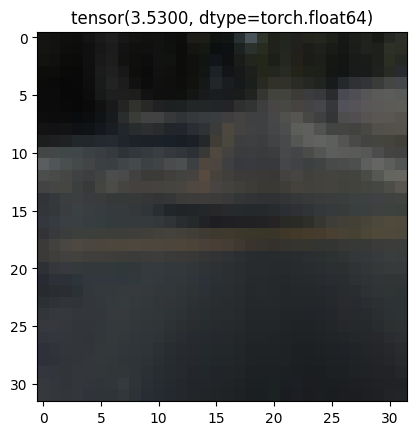

In [8]:
"""DATASET"""

try:
    from google.colab import drive
    drive.mount("/content/drive")
    DATA_DIR = save_dir
    LABELS_PATH = DATA_DIR/"data.txt"
except:
    DATA_DIR = save_dir
    if not DATA_DIR.exists():
        print("Dataset doesnt exist or not preprocessed")
    else:
        LABELS_PATH = DATA_DIR/"data.txt"
!pip install imageio
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import imageio as iio
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np

class DrivingDataset(Dataset):
    def __init__(self, labels_path, data_dir, transform=None):
        with open(Path(labels_path), "r") as f:
            self.labels = f.readlines()
            f.close()
        self.data_dir = Path(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index) :
        img_path, label = self.labels[index].split()
        label=float(label)
        img = iio.imread(self.data_dir/img_path)

        if self.transform:
            img = self.transform(img)

        return (img, label)
        

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = DrivingDataset(labels_path=LABELS_PATH, data_dir=DATA_DIR, transform=transform)
# print(len(dataset))
train_size = int(0.8 * len(dataset))
test_size = int(len(dataset)-train_size)
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

for i, (imgs, labels) in enumerate(train_loader):
    img = imgs[0]
    label = labels[0]
    plt.imshow(np.transpose(img,  (1, 2, 0)))
    plt.title(label)
    # plt.axis('off')
    plt.show()
    break

In [9]:
"""MODEL"""

import torch 
import torch.nn as nn

"""MODEL"""

import torch.nn as nn
import torch.nn.functional as F
import math

class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.img_size = config["img_size"]
        self.num_channels = config["num_channels"]
        self.patch_size = config["patch_size"]
        self.embed_dim = config["embed_dim"]
        
        self.num_patches = (self.img_size//self.patch_size)**2
        self.projection = nn.Conv2d(self.num_channels, self.embed_dim, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.projection(x)
        # print(x.shape)
        x = x.flatten(2).transpose(1,2)
        return x


class Embeddings(nn.Module):
    # Patch Embeddings + (CLS Token + Positional Embeddings )
    def __init__(self, config):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(config)
        self.embed_dim = config["embed_dim"]
        self.cls_token = nn.Parameter(torch.randn(1,1,self.embed_dim))
        self.positional_embeddings = nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches+1, self.embed_dim))
        self.dropout = nn.Dropout(config["dropout"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        cls_token = self.cls_token.expand(batch_size, -1, -1) # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.positional_embeddings
        x = self.dropout(x)
        return x

class AttentionHead(nn.Module):
    def __init__(self, attention_head_size,config):
        super().__init__()
        self.embed_dim = config["embed_dim"]
        self.attention_head_size = attention_head_size
        self.bias = config["bias"]
        
        self.query = nn.Linear(self.embed_dim, self.attention_head_size, bias=self.bias)
        self.key = nn.Linear(self.embed_dim, self.attention_head_size, bias=self.bias)
        self.value = nn.Linear(self.embed_dim, self.attention_head_size, bias=self.bias)

        self.dropout = nn.Dropout(config["dropout"])

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        attention_scores = torch.matmul(q, k.transpose(-1,-2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_scores = nn.functional.softmax(attention_scores, dim=-1)
        attention_scores = self.dropout(attention_scores)
        attention_out = torch.matmul(attention_scores, v)
        
        return attention_out

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config["embed_dim"]
        self.num_heads = config["num_heads"]
        self.head_size = self.embed_dim//self.num_heads
        self.all_head_size = self.head_size * self.num_heads
        self.dropout = config["dropout"]
        self.qkv_bias = config["bias"]

        self.heads = nn.ModuleList([
            AttentionHead(
                self.head_size,
                config
            ) for _ in range(self.num_heads)
        ])

        self.attention_mlp = nn.Linear(self.all_head_size, self.embed_dim)
        self.out_dropout = nn.Dropout(config["dropout"])

    def forward(self, x):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output in attention_outputs], dim=-1) #concat attention for each head
        attention_output = self.attention_mlp(attention_output)
        attention_output = self.out_dropout(attention_output)

        return attention_output
        

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config["embed_dim"]
        self.hidden_dim = config["hidden_dim"]
        self.fc1 = nn.Linear(self.embed_dim, self.hidden_dim)
        # self.act = nn.GELU()
        self.act=NewGELUActivation()
        self.fc2 = nn.Linear(self.hidden_dim, self.embed_dim)
        self.dropout=nn.Dropout(config["dropout"])

    def forward(self,x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim=config["embed_dim"]
        self.num_heads = config["num_heads"]
        self.hidden_dim = config["hidden_dim"]
        self.attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim)
        self.mlp = MLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim)

    def forward(self,x):
        attention_output = self.attention(self.layer_norm1(x))
        x = x+attention_output
        mlp_out = self.mlp(self.layer_norm2(x))
        x = x+mlp_out
        return x
        
    
class Encoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.blocks = nn.ModuleList([Block(config) for _ in range(config["num_hidden_layers"])])
    def forward(self,x ):
        all_attentions = []
        for block in self.blocks:
            x = block(x)
        return x


class ViT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.img_size = config["img_size"]
        self.embed_dim = config["embed_dim"]
        self.num_classes = config["num_classes"]
    
        self.embeddings = Embeddings(config)
        self.encoder = Encoder(config)
    
        self.classifier = nn.Linear(self.embed_dim, self.num_classes)

        self.apply(self._init_weights)

    def forward(self, x):
        embedding_output = self.embeddings(x)
        encoder_output = self.encoder(embedding_output)
        classification = self.classifier(encoder_output[:, 0, :])
        return classification


    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.positional_embeddings.data = nn.init.trunc_normal_(
                module.positional_embeddings.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.positional_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.cls_token.dtype)

            


In [10]:
"""UTILS"""
import json
from pathlib import Path

CHECKPOINT_DIR = root_dir/"e2e_steering_ckpt"
EXPERIMENT_DIR = root_dir/"experiments"

def save_checkpoint(state_dict, epoch, path):
    p = Path(path)
    if not p.exists():
        print("Creating folder")
        p.mkdir(parents=True, exist_ok=True)

    model_details = {
        "epoch":epoch,
        "state_dict": state_dict,
    }
    torch.save(model_details, f"{p}/vit_cifar10_{epoch}.pth")
    print(f"model saved at path : {p}/vit_cifar10_{epoch}.pth")


def load_pretrained(model, path, epoch):
    model.load_state_dict(torch.load(f"{path}/vit_cifar10_{epoch}.pth")["state_dict"])
    return model

def save_experiment(model, epoch, config, train_losses, test_losses, accuracies, path):
    exp_data = {
        "train_losses":train_losses,
        "test_losses":test_losses,
        "accuracies":accuracies,
        "epoch":epoch,
    }
    exp_name = config["exp_name"]
    config_file = path/f"{exp_name}"/"config.json"
    metrics_file = path/f"{exp_name}"/"metrics.json"
    files = [config_file , metrics_file]
    for file in files:
        if file.exists():
            print(f"{file} exists")
        else:
            file.parent.mkdir(parents=True, exist_ok=True)
            file.touch()
            print(f"{file} created")

    with open(config_file, "w") as f:
        json.dump(config, f, sort_keys=True, indent=4)
    with open(metrics_file, "w") as f:
        json.dump(exp_data, f, sort_keys=True, indent=4)

    save_checkpoint(model.state_dict(), epoch, path/f"{exp_name}")

def load_experiment(model ,exp_name, path):
    with open(path/f"{exp_name}"/"metrics.json", 'r') as file:
      data = json.load(file)
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    accuracies=data["accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path/exp_name, epoch)

    return model, train_losses, test_losses, accuracies, epoch
    
    

In [11]:
"""CONFIG"""


config = {
    "img_size":32,
    "patch_size":4,
    "num_channels":3,
    "embed_dim":48*16,
    "dropout":0.0,
    "bias":True,
    "num_heads":4,
    "hidden_dim":4*48*16,
    "num_hidden_layers":9,
    "num_classes":1,
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "exp_name" : 'e2e--10-epochs',
    "num_epochs":10,
    "lr":0.01,
    "save_model_every" :0

}

In [12]:
import torch.optim as optim
import torch
class Trainer:
    def __init__(self, model, optimizer, criterion, device, path=CHECKPOINT_DIR):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.path=path
        self.exp_dir = EXPERIMENT_DIR

    def train(self, train_loader, test_loader, num_epochs, save_model_every_n_epochs=0):
        train_losses = []
        test_losses = []
        accuracies = [] 

        for i in range(num_epochs):
            train_loss = self.train_epoch(train_loader)
            accuracy, test_loss = self.evaluate(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != num_epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.model.state_dict(), i+1, train_losses, test_losses, accuracies, self.path)

        save_experiment(self.model, num_epochs, config, train_losses, test_losses, accuracies, self.exp_dir)

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        for i, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(self.device)
            labels = torch.tensor(labels).float().to(self.device)
            
            self.optimizer.zero_grad()
            predictions = self.model(imgs)
            predictions = predictions.view(predictions.shape[0]).float()
            loss = self.criterion(predictions, labels)
            print(loss)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()* len(imgs)

        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for i, (imgs, labels) in enumerate(test_loader):
                imgs = imgs.to(self.device)
                labels = torch.tensor(labels).float().to(self.device)

                predictions = self.model(imgs)
                predictions = predictions.view(predictions.shape[0]).float()
                
                loss = self.criterion(predictions, labels)
                total_loss += loss.item() * len(imgs)

                 # Calculate the accuracy
                predictions = torch.argmax(predictions, dim=1)
                correct += torch.sum(predictions == labels).item()

        accuracy = correct / len(test_loader.dataset)
        avg_loss = total_loss / len(test_loader.dataset)
        return accuracy, avg_loss
            

def main():
    save_model_every_n_epochs = config["save_model_every"]
    model = ViT(config)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-2)
    criterion = nn.MSELoss()
    trainer = Trainer(model, optimizer, criterion, device=config["device"])
    trainer.train(train_loader, test_loader, config["num_epochs"], save_model_every_n_epochs=save_model_every_n_epochs)

In [13]:
"""TRAINING"""

if __name__ == "__main__":
    main()


/tmp/ipykernel_32207/3186932329.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(self.data_dir/img_path)
/tmp/ipykernel_32207/98580535.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).float().to(self.device)


tensor(7781.1128, grad_fn=<MseLossBackward0>)
tensor(4322.9922, grad_fn=<MseLossBackward0>)
tensor(1940.8619, grad_fn=<MseLossBackward0>)
tensor(6585692., grad_fn=<MseLossBackward0>)
tensor(1896.4395, grad_fn=<MseLossBackward0>)
tensor(680854.3750, grad_fn=<MseLossBackward0>)
tensor(39915.9375, grad_fn=<MseLossBackward0>)
tensor(8052607.5000, grad_fn=<MseLossBackward0>)
tensor(642006.1250, grad_fn=<MseLossBackward0>)
tensor(375310.0625, grad_fn=<MseLossBackward0>)


In [ ]:
"""VIS Loss, ACC"""

"""
def load_experiment(model ,exp_name, path):
    data = json.load(path/f"exp_name"/"metrics.json")
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    accuracies=data["accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path, epoch)

    return model, train_losses, test_losses, accuracies, epoch
    """


import matplotlib.pyplot as plt

model = ViT(config)
_, train_losses, test_losses, accuracies,_ = load_experiment(model, config["exp_name"], EXPERIMENT_DIR)
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()